# 讀取數據和模型 然後取得預測值

In [7]:
import os
from utils import *
import joblib
os.listdir('../model')

['Critic.pkl', 'PAagent.pkl', 'stream_lasso_weight.pkl']

In [8]:
os.listdir('../data')

['dataset.pkl', 'tag_cleaned.csv', 'train_cleaned.csv']

In [9]:
tag = pd.read_csv('../data/tag_cleaned.csv')
tag = tag[['TAG','chinese','min','max']]
tag = tag.set_index('TAG')

In [10]:
agent = joblib.load('../model/PAagent.pkl')

In [11]:
set_state = [0.99,30]
set_request = 8200

In [12]:
state = set_state
request = set_request
advice,output,stream,單耗,蒸氣單耗 = agent.get_advice(state,request)
#tag = tag.loc[advice.index,:]
print('state',state)
print('request',request)
print('output',output[0][0])
print('stream',stream[0][0])
print('單耗',單耗)
print('蒸氣單耗',蒸氣單耗)
#c1 = tag.loc[col,'min'] - advice['min'] > 0
#c2 = tag.loc[col,'max'] - advice['max'] < 0
#advice['超出規格'] = c1|c2
advice

state [0.99, 30]
request 8200
output 8104.3364
stream 10945.148
單耗 0.893671
蒸氣單耗 0.6617188


,chinese,mean,max,min
MLPAP_FQ-0619.PV,OX入料量,7242.610352,7243.885254,7241.365723
MLPAP_TJC-0627.PV,OX預熱器出口溫度,151.365265,151.374023,151.359436
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,182.431839,182.473587,182.397034
MLPAP_FR-0632.PV,汽機風量,84.542389,84.543983,84.539810
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,362.371796,362.378693,362.366730
MLPAP_PIC-0761.PV,鹽浴冷卻器(E212)出口壓力,48.374786,48.384548,48.366390
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,58.561733,58.564156,58.559372
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,182.513611,182.543777,182.492203
MLPAP_TRC-0747.PV,E220出口溫度,168.404709,168.447784,168.354141
MLPAP_TJ-0881.PV,液態冷凝器出口溫度,136.885422,136.900299,136.873871


In [13]:
#advice = advice.drop('超出規格',axis=1)

# 把預測值跟真實值比較

In [14]:
tag = pd.read_csv('../data/tag_cleaned.csv',index_col=0)
tag_dict = dict(zip(tag.TAG,tag.chinese))
data = joblib.load('../data/dataset.pkl')
data.keys()

#load real data
state = data['mm_state'].inverse_transform(data['state'])
action = [data['mm_action'].inverse_transform(i) for i in data['action']]
output = data['mm_output'].inverse_transform(data['output'])
stream = data['mm_stream'].inverse_transform(data['stream'])

#calculate distance
distance_state = ((state - set_state)**2).sum()
distance_output = (output - set_request)**2
min_distance_idx =  np.argmin(distance_state + distance_output)

# show result
real_feed = action[min_distance_idx][0][0]
real_output = output[min_distance_idx][0]
real_state = state[min_distance_idx]
real_stream = stream[min_distance_idx][0]
print('state',real_state)
print('output',real_output)
print('stream',real_stream)
print('單耗',real_feed/real_output)
print('蒸氣單耗',real_feed/real_stream)

real = pd.DataFrame(action[min_distance_idx],columns=data['action_col'])
real.loc['mean'] = real.mean(axis=0)
real.loc['max'] = real.max(axis=0)
real.loc['min'] = real.min(axis=0)
real = real.iloc[-3:,:].T
real['chinese'] = real.index.map(tag_dict)
real = real[advice.columns]
real

state [ 0.66190174 25.95014437]
output 8200.0
stream 41106.11820220947
單耗 0.9260365853658538
蒸氣單耗 0.1847291919574115


,chinese,mean,max,min
MLPAP_FQ-0619.PV,OX入料量,7596.333333,7598.500000,7593.500000
MLPAP_TJC-0627.PV,OX預熱器出口溫度,154.014731,154.038895,154.000000
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,182.894987,183.339584,182.600006
MLPAP_FR-0632.PV,汽機風量,82.041805,82.080002,82.004997
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,351.211943,351.239136,351.200012
MLPAP_PIC-0761.PV,鹽浴冷卻器(E212)出口壓力,49.299999,49.299999,49.299999
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,60.036279,60.060955,60.000000
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,180.700927,180.880196,180.610451
MLPAP_TRC-0747.PV,E220出口溫度,169.300003,169.300003,169.300003
MLPAP_TJ-0881.PV,液態冷凝器出口溫度,138.760485,138.800003,138.739105


delta


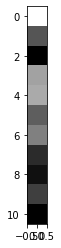

In [15]:
# 比較預測值跟 真實值之間的差異
delta = abs(advice.iloc[:,[1]] - real.iloc[:,[1]]) / real.iloc[:,[1]]
delta = delta[:-1]
print('delta')
plt.imshow(delta.values,cmap='gray')

# 畫出趨勢圖

In [28]:
def get_actor_action(state,request):
    advice,output,stream,_,_ = agent.get_advice(state,request)
    return advice

In [29]:
def get_real_action(state,request):
    
    #load real data
    state = data['mm_state'].inverse_transform(data['state'])
    action = [data['mm_action'].inverse_transform(i) for i in data['action']]
    output = data['mm_output'].inverse_transform(data['output'])
    stream = data['mm_stream'].inverse_transform(data['stream'])
    
    #calculate distance
    distance_state = ((state - set_state)**2).sum()
    distance_output = (output - set_request)**2
    min_distance_idx =  np.argmin(distance_state + distance_output)
    
    # show result
    real = pd.DataFrame(action[min_distance_idx],columns=data['action_col'])
    real.loc['mean'] = real.mean(axis=0)
    real.loc['max'] = real.max(axis=0)
    real.loc['min'] = real.min(axis=0)
    real = real.iloc[-3:,:].T
    real['chinese'] = real.index.map(tag_dict)
    real = real[advice.columns]
    return real

In [30]:
pred = {}
real = {}
for t in [0,0.25,0.5,0.75]:
    a = get_actor_action([t,30],8000)
    b = get_real_action([t,30],8000)
    pred[t] = a
    real[t] = b

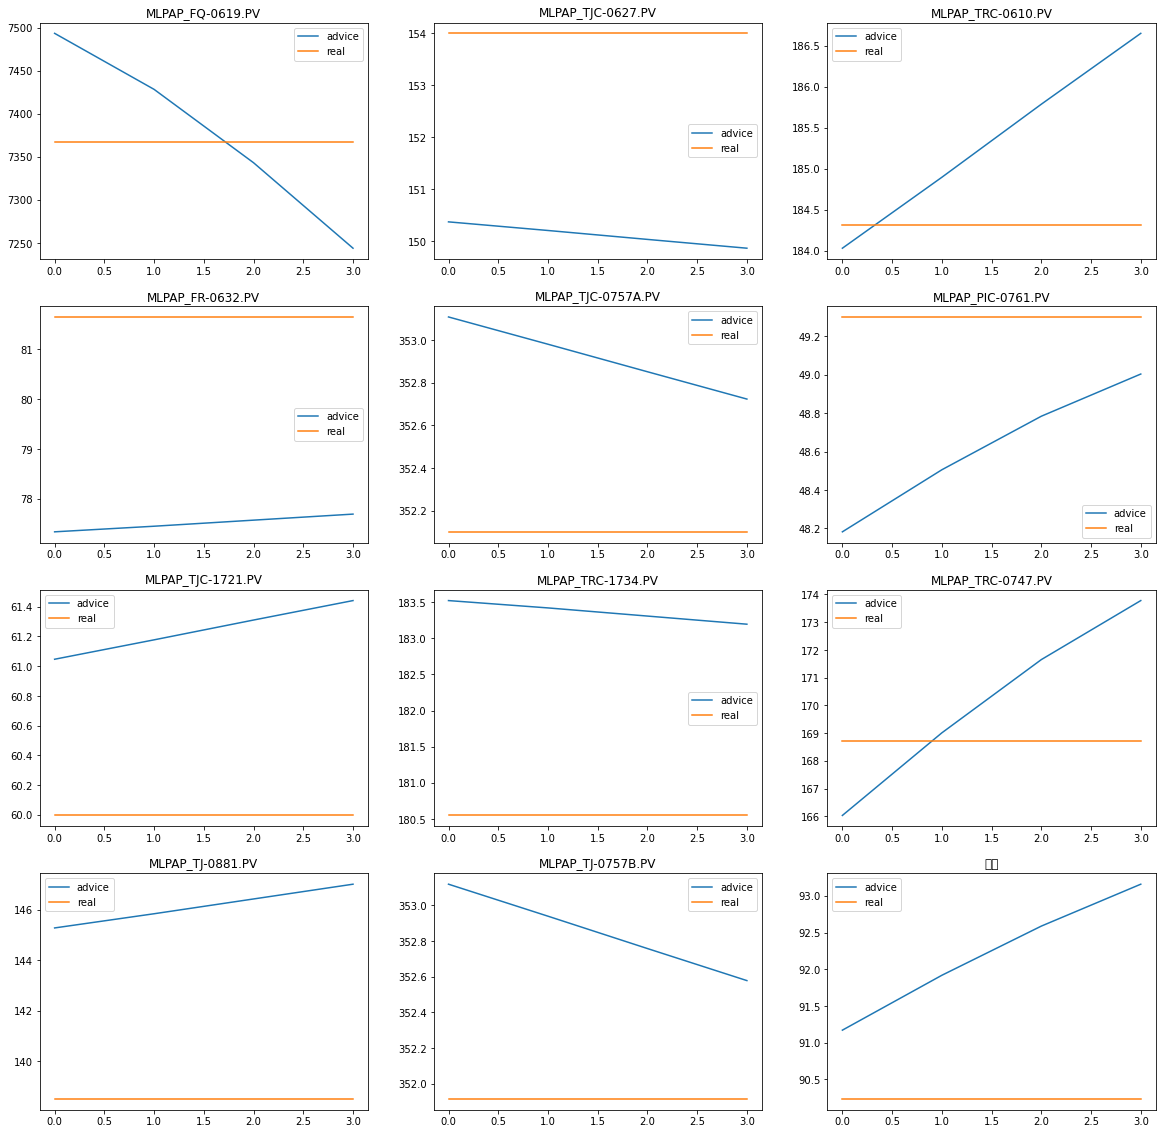

In [31]:
plt.figure(figsize=(20,20))
for idx,y_name in enumerate(data['action_col']):
    plt.subplot(4,3,idx+1)
    plt.plot([v.loc[y_name,'mean'] for k,v in pred.items()],label='advice')
    plt.plot([v.loc[y_name,'mean'] for k,v in real.items()],label='real')
    plt.title(y_name)
    plt.legend()
plt.show()